# Setup

In [1]:
from pathlib import Path
import pandas as pd
import json
from schema import Model
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from utils import format_filesize

In [2]:
def parse_experiment_output(root_folder, metric="duration"):
    input_files = sorted(root_folder.glob("experiment-*/provenance/inputs.json"))
    output_files = sorted(root_folder.glob("experiment-*/provenance/outputs.json"))
    provenance_results = [
        Model(
            inputs=json.loads(f.read_text()),
            outputs=json.loads(output_files[idx].read_text())
        ) for idx, f in enumerate(input_files)
    ]

    configs = {}

    data = []
    for r in provenance_results:
        config = r.inputs.parameters.setup.lower()
        dataset = r.inputs.parameters.dataset
        total_size = sum([l.size for l in r.outputs.sizes.individual])
        sf = r.inputs.parameters.storageFormat.replace("File", "").replace("Format", "")
        compressed = "(true)" in sf or sf.lower() in ["parquet", "orc", "avro"]
        sf = sf.replace("()", "").replace("(true)", "").replace("(false)", "")
        if compressed:
            sf += "-C"

        if dataset not in configs:
            file = root_folder / "configs" / (dataset + ".properties")
            pairs = {
                line.split("=")[0].strip().replace(f"graph.{dataset}.", ""): line.split("=")[1].strip() 
                for line in open(file).read().splitlines() if "=" in line
            }
            configs[dataset] = pairs
        else:
            pairs = configs[dataset]
        
        data.append({
            "config": config,
            "algorithm": r.inputs.parameters.algorithm,
            "dataset": dataset,
            "run": r.inputs.parameters.runNr,
            "storage_format": sf,
            "compressed": compressed,
            "output_size": r.outputs.sizes.total,
            "total_size": (total_size if config != "baseline" else r.outputs.sizes.total),
            "nr_executors": r.inputs.parameters.executorCount,
            "nr_vertices": int(pairs["meta.vertices"]),
            "iterations": len([e for e in r.outputs.graph.edges if e.type == "operation"]),
            "duration": r.outputs.duration.amount / 10**9, # in seconds
            "size": sum([s.size for s in r.outputs.sizes.individual]),
        })
    return pd.DataFrame(data)

In [5]:
sns.set_theme(style="whitegrid", font_scale=1.5)

In [6]:
palette = sns.color_palette("tab10")
algorithm_colors = {"PageRank": palette[0], "WCC": palette[1], "SSSP": palette[2], "BFS": palette[3]}

In [7]:
root_dir = Path("/Users/gm/vu/thesis/impl/provxlib/results/src/plots.ipynb").parent.parent
plot_dir = root_dir / "plots"

In [151]:
node_sizes = pd.read_csv("/Users/gm/vu/thesis/impl/provxlib/results/data/node-sizes.csv")
node_sizes

,total_size,dataset
0,30025298,cit-Patents
1,8266855,datagen-7_5-fb
2,9844505,datagen-7_6-fb
3,175245468,datagen-7_7-zf
4,219958278,datagen-7_8-zf
5,18190864,datagen-7_9-fb
6,50232462,datagen-8_4-fb
7,60699993,datagen-8_5-fb
8,139876016,datagen-8_9-fb
9,412051,dota-league


# Storage formats

In [123]:
data_dir = Path("das6") / "storageformats-scaling"
storage_formats = parse_experiment_output(root_dir / "data" / data_dir)
storage_formats["per_iter"] = storage_formats["duration"] / storage_formats["iterations"]
#storage_formats

In [142]:
storage_baseline = storage_formats[(storage_formats["storage_format"] == "Text") & (storage_formats["nr_executors"] == 8)]
#storage_baseline

In [139]:
graph_sizes

,bytes,dataset
0,124908991,cit-Patents
1,170225435,datagen-7_5-fb
2,209704451,datagen-7_6-fb
3,455579949,datagen-7_7-zf
4,570698605,datagen-7_8-zf
5,420676827,datagen-7_9-fb
6,1296792721,datagen-8_4-fb
7,1591057153,datagen-8_5-fb
8,3989258568,datagen-8_9-fb
9,119883349,dota-league


In [146]:
storage_baseline

,config,algorithm,dataset,run,storage_format,compressed,output_size,total_size,nr_executors,nr_vertices,iterations,duration,size,per_iter
99,storageformats,PageRank,wiki-Talk,1,Text,False,30015895,74086501,8,2394385,35,77.556950,74086501,2.215913
119,storageformats,PageRank,datagen-7_7-zf,1,Text,False,241148008,480900463,8,13180508,35,276.527149,480900463,7.900776
121,storageformats,SSSP,datagen-8_4-fb,1,Text,False,69277882,1498335302,8,3809084,36,236.426822,1498335302,6.567412
145,storageformats,WCC,kgs,1,Text,False,9875854,86493678,8,832247,21,41.867450,86493678,1.993688
185,storageformats,BFS,datagen-7_6-fb,1,Text,False,13615240,227952964,8,754147,27,41.689845,227952964,1.544068
237,storageformats,BFS,datagen-7_5-fb,1,Text,False,11434015,189922202,8,633432,29,44.521784,189922202,1.535234
286,storageformats,WCC,datagen-7_5-fb,1,Text,False,11434015,58425032,8,633432,13,45.820568,58425032,3.524659
361,storageformats,BFS,datagen-7_7-zf,1,Text,False,241148008,1395649590,8,13180508,9,69.720655,1395649590,7.746739
371,storageformats,SSSP,dota-league,1,Text,False,717901,5396709,8,61170,14,37.003884,5396709,2.643135
389,storageformats,WCC,datagen-7_9-fb,1,Text,False,25128799,129855334,8,1387587,13,71.532095,129855334,5.502469


In [160]:
gg = graph_sizes.rename(columns={"total_size": "baseline_graph_size"})
gg2 = pd.merge(storage_baseline, gg, on=["dataset"])
gg2["blowup"] = gg2["total_size"] / gg2["baseline_graph_size"]
#gg2



<Axes: xlabel='blowup'>

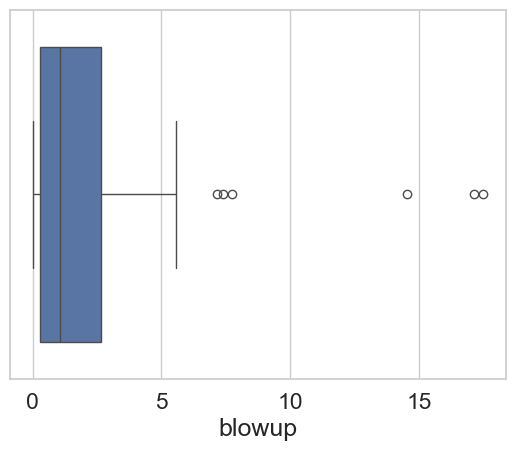

In [163]:
sns.boxplot(gg2, x="blowup")

## Duration

In [125]:
def duration_plots(df, x="per_iter", y="storage_format", ylabel="Storage formats"):
    for algorithm in df["algorithm"].unique():
        obs = df[df["algorithm"] == algorithm]
        order = obs.groupby(by=[y])[x].median().sort_values(ascending=False).index
        b = sns.boxplot(data=obs, x=x, y=y, hue="algorithm", order=order, palette=algorithm_colors)
        b.set_xlim(0, 30)
        b.set_xlabel("Duration (s)")
        b.set_ylabel(ylabel)
        write_dir = (plot_dir / data_dir)
        write_dir.mkdir(exist_ok=True, parents=True)
        plt.savefig(write_dir / f"duration-{algorithm}.svg", bbox_inches='tight')
        plt.clf()

In [126]:
duration_plots(storage_formats[storage_formats["nr_executors"] == 8])

<Figure size 640x480 with 0 Axes>

## Sizes

In [127]:
def sizes_plot(df):
    xmin, xmax = df[df["size"] > 0]["size"].min(), df[df["size"] > 0]["size"].max()
    
    for algorithm in df["algorithm"].unique():
        if len(df[df["size"] > 0]) > 0:
            print("warning: some rows have size equal to 0")
        obs = df[(df["algorithm"] == algorithm) & (df["size"] > 0)].drop_duplicates()
        order = obs.groupby(by=["storage_format"])["size"].median().sort_values(ascending=False).index
        b = sns.boxplot(data=obs, x="size", y="storage_format", hue="algorithm", order=order, palette=algorithm_colors)
        b.set_xscale("log")
        b.set_xlim(xmin, xmax)
        b.set_xlabel("Size (bytes)")
        b.set_ylabel("Storage formats")
        ticks = np.logspace(np.log10(xmin)-0.1, np.log10(xmax)+0.1, 10)
        b.set_xticks(ticks=ticks, labels=[f"{format_filesize(l)[0]:.0f} {format_filesize(l)[1]}" for l in ticks], rotation=45)
        sns.move_legend(b, "lower right")
        write_dir = (plot_dir / data_dir)
        write_dir.mkdir(exist_ok=True, parents=True)
        plt.savefig(write_dir / f"size-{algorithm}.svg", bbox_inches='tight')
        plt.clf()

In [128]:
gray = (178/255, 190/255, 181/255)
#algorithm_colors = {"PageRank": gray, "WCC": gray, "SSSP": gray, "BFS": gray}
sizes_plot(storage_formats[storage_formats["nr_executors"] == 8])

<Figure size 640x480 with 0 Axes>

In [21]:
baseline = parse_experiment_output(root_dir / "data" / "das6" / "baseline-scaling")
#baseline

In [137]:
def merge_compare(baseline, rhs, metric="duration", on=["algorithm", "dataset"], name="overhead"):
    df = baseline.groupby(by=on).sum(metric).reset_index()
    df.rename(columns={metric: f"baseline_{metric}"}, inplace=True)
    dff = pd.merge(rhs, df[on+[f"baseline_{metric}"]], on=on)
    dff[name] = dff[metric] / dff[f"baseline_{metric}"]
    return dff

# Tracing

In [30]:
data_dir = Path("das6") / "tracing"
print(root_dir / "data" / data_dir)
tracing = parse_experiment_output(root_dir / "data" / data_dir)
#tracing

/Users/gm/vu/thesis/impl/provxlib/results/data/das6/tracing


In [117]:
tracing_compare = merge_compare(baseline[baseline["nr_executors"] == 8], tracing, metric="duration")
#len(tracing_compare)
tracing_compare = tracing_compare[tracing_compare["overhead"] > 0.95]
#tracing_compare

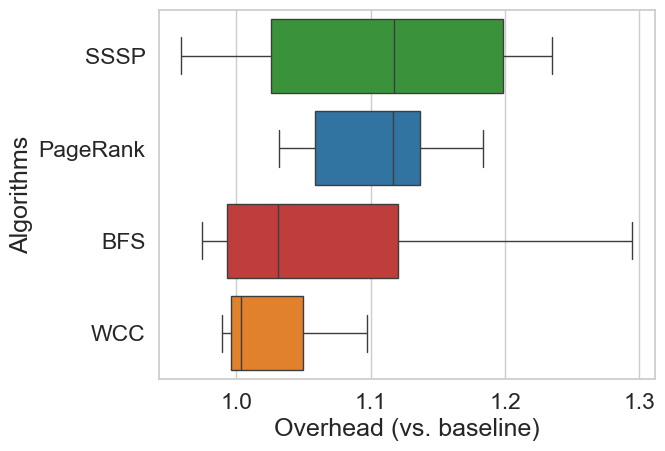

In [51]:
order = tracing_compare.groupby(by=["algorithm"])["overhead"].median().sort_values(ascending=False).index
b = sns.boxplot(data=tracing_compare, x="overhead", y="algorithm", hue="algorithm", palette=algorithm_colors, order=order)
b.set_xlabel("Overhead (vs. baseline)")
b.set_ylabel("Algorithms")
b.patch.set_alpha(0.)
write_dir = (plot_dir / data_dir)
write_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(write_dir / f"overhead.svg", bbox_inches='tight')

# `joinVertices` op only

In [82]:
data_dir = Path("das6") / "20231211-joinvertices-op-only"
joinVertices = parse_experiment_output(root_dir / "data" / data_dir)
#joinVertices

In [83]:
joinVertices_compare_duration = merge_compare(storage_baseline[storage_baseline["nr_executors"] == 8], joinVertices, metric="duration")
joinVertices_compare_duration = joinVertices_compare_duration[joinVertices_compare_duration["algorithm"] != "PageRank"]
#joinVertices_compare_duration

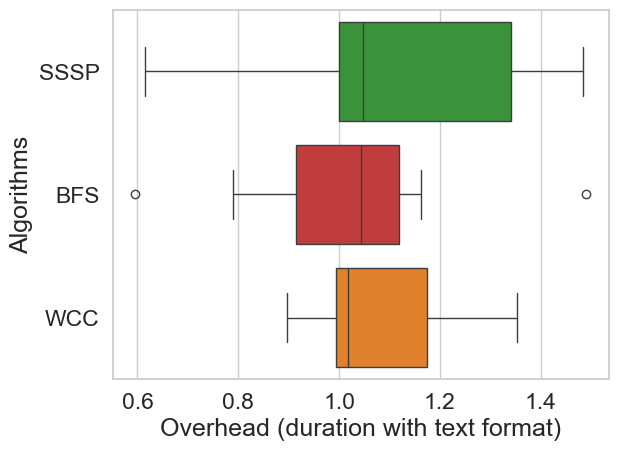

In [85]:
order = joinVertices_compare_duration.groupby(by=["algorithm"])["overhead"].median().sort_values(ascending=False).index
b = sns.boxplot(data=joinVertices_compare_duration, x="overhead", y="algorithm", hue="algorithm", palette=algorithm_colors, order=order)
b.set_xlabel("Overhead (duration with text format)")
b.set_ylabel("Algorithms")
write_dir = (plot_dir / data_dir)
write_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(write_dir / f"overhead-duration.svg", bbox_inches='tight')

In [116]:
joinVertices_compare_size = merge_compare(storage_baseline[storage_baseline["nr_executors"] == 8], joinVertices, metric="size")
joinVertices_compare_size = joinVertices_compare_size[joinVertices_compare_size["algorithm"] != "PageRank"]
#joinVertices_compare_size

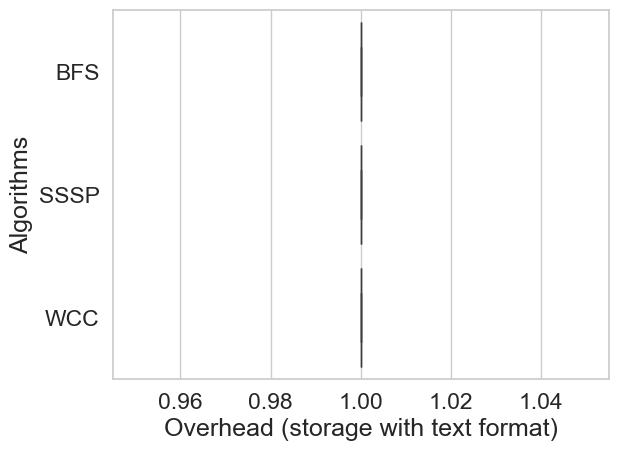

In [115]:
order = joinVertices_compare_size.groupby(by=["algorithm"])["overhead"].median().sort_values(ascending=False).index
b = sns.boxplot(data=joinVertices_compare_size, x="overhead", y="algorithm", hue="algorithm", palette=algorithm_colors, order=order)
b.set_xlabel("Overhead (storage with text format)")
b.set_ylabel("Algorithms")
write_dir = (plot_dir / data_dir)
write_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(write_dir / f"overhead-size.svg", bbox_inches='tight')

# Smart pruning

In [89]:
data_dir = Path("das6") / "20231211-smartpruning"
smart_pruning = parse_experiment_output(root_dir / "data" / data_dir)
#smart_pruning

In [90]:
smart_pruning_compare_duration = merge_compare(storage_baseline[storage_baseline["nr_executors"] == 8], smart_pruning, metric="duration")
#smart_pruning_compare_duration

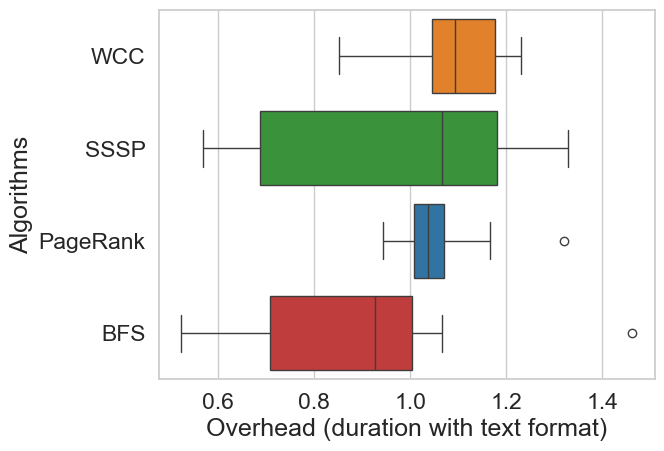

In [91]:
order = smart_pruning_compare_duration.groupby(by=["algorithm"])["overhead"].median().sort_values(ascending=False).index
b = sns.boxplot(data=smart_pruning_compare_duration, x="overhead", y="algorithm", hue="algorithm", palette=algorithm_colors, order=order)
b.set_xlabel("Overhead (duration with text format)")
b.set_ylabel("Algorithms")
write_dir = (plot_dir / data_dir)
write_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(write_dir / f"overhead-duration.svg", bbox_inches='tight')

In [131]:
smart_pruning_compare_size = merge_compare(storage_baseline[storage_baseline["nr_executors"] == 8], smart_pruning, metric="size")
#smart_pruning_compare_size

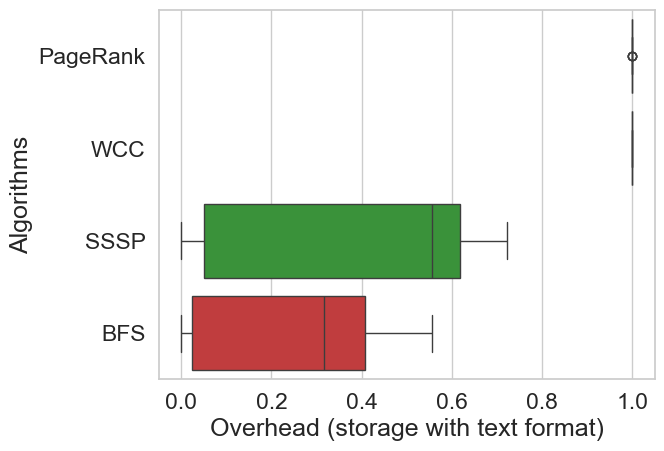

In [92]:
order = smart_pruning_compare_size.groupby(by=["algorithm"])["overhead"].median().sort_values(ascending=False).index
b = sns.boxplot(data=smart_pruning_compare_size, x="overhead", y="algorithm", hue="algorithm", palette=algorithm_colors, order=order)
b.set_xlabel("Overhead (storage with text format)")
b.set_ylabel("Algorithms")
write_dir = (plot_dir / data_dir)
write_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(write_dir / f"overhead-size.svg", bbox_inches='tight')

# Combined

In [94]:
data_dir = Path("das6") / "combined-scaling"
combined = parse_experiment_output(root_dir / "data" / data_dir)
#combined

In [104]:
combined_compare_duration = merge_compare(storage_baseline[storage_baseline["nr_executors"] == 8], combined[combined["nr_executors"] == 8], metric="duration")
#combined_compare_duration

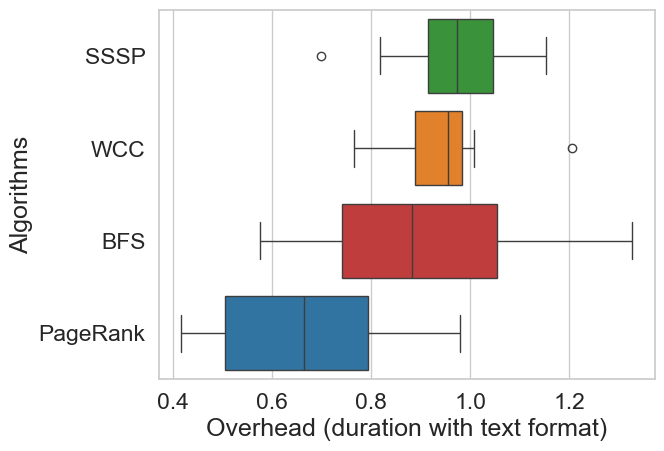

In [106]:
order = combined_compare_duration.groupby(by=["algorithm"])["overhead"].median().sort_values(ascending=False).index
b = sns.boxplot(data=combined_compare_duration, x="overhead", y="algorithm", hue="algorithm", palette=algorithm_colors, order=order)
b.set_xlabel("Overhead (duration with text format)")
b.set_ylabel("Algorithms")
write_dir = (plot_dir / data_dir)
write_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(write_dir / f"overhead-duration.svg", bbox_inches='tight')

In [112]:
#combined_compare_size = merge_compare(storage_baseline[storage_baseline["nr_executors"] == 8], combined[(combined["nr_executors"] == 8) & (combined["size"] > 0)], metric="size")
combined_compare_size = merge_compare(storage_baseline[storage_baseline["nr_executors"] == 8], combined[(combined["nr_executors"] == 8) & (combined["size"] > 0)], metric="size")

#combined_compare_size

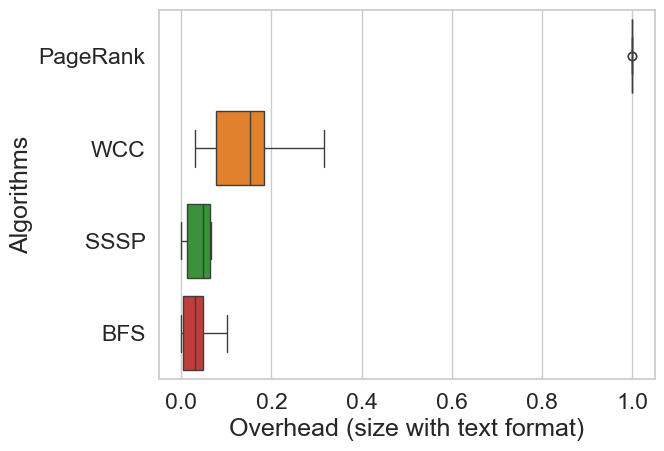

In [113]:
order = combined_compare_size.groupby(by=["algorithm"])["overhead"].median().sort_values(ascending=False).index
b = sns.boxplot(data=combined_compare_size, x="overhead", y="algorithm", hue="algorithm", palette=algorithm_colors, order=order)
b.set_xlabel("Overhead (size with text format)")
b.set_ylabel("Algorithms")
write_dir = (plot_dir / data_dir)
write_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(write_dir / f"overhead-size.svg", bbox_inches='tight')

In [164]:
gg_combined = graph_sizes.rename(columns={"total_size": "baseline_graph_size"})
gg2_combined = pd.merge(combined, gg_combined, on=["dataset"])
gg2_combined["blowup"] = gg2_combined["total_size"] / gg2_combined["baseline_graph_size"]

,config,algorithm,dataset,run,storage_format,compressed,output_size,total_size,nr_executors,nr_vertices,iterations,duration,size,baseline_graph_size,blowup
0,combined,BFS,datagen-8_4-fb,1,Text,False,69277882,48037026,4,3809084,35,252.655813,48037026,1296792721,0.037043
1,combined,PageRank,datagen-8_4-fb,1,Text,False,69277882,138984968,2,3809084,35,264.320341,138984968,1296792721,0.107176
2,combined,BFS,datagen-8_4-fb,1,Text,False,69277882,48037026,1,3809084,35,168.823228,48037026,1296792721,0.037043
3,combined,BFS,datagen-8_4-fb,1,Text,False,69277882,48037026,8,3809084,35,257.589570,48037026,1296792721,0.037043
4,combined,SSSP,datagen-8_4-fb,1,Text,False,69277882,68270572,2,3809084,36,272.639362,68270572,1296792721,0.052646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,combined,PageRank,datagen-7_7-zf,1,Text,False,241148008,480899925,4,13180508,35,114.504216,480899925,455579949,1.055577
156,combined,PageRank,datagen-7_7-zf,1,Text,False,241148008,480901699,8,13180508,35,115.166834,480901699,455579949,1.055581
157,combined,WCC,datagen-7_7-zf,1,Text,False,241148008,232491087,1,13180508,57,254.772539,232491087,455579949,0.510319
161,combined,PageRank,datagen-7_7-zf,1,Text,False,241148008,480901481,2,13180508,35,123.412177,480901481,455579949,1.055581


<Axes: xlabel='blowup'>

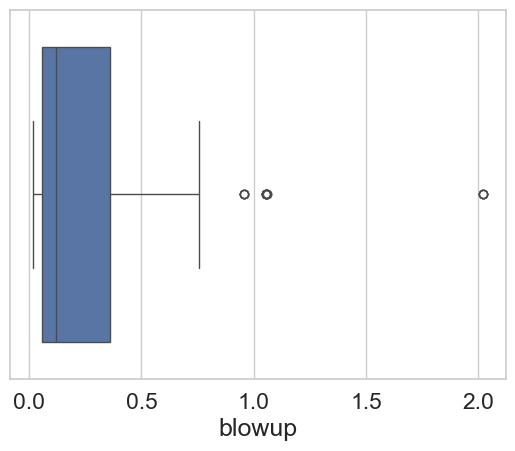

In [177]:
sns.boxplot(gg2_combined[gg2_combined["size"] > 1024**2], x="blowup")

In [181]:
storage_baseline["scenario"] = "All operations"
joinVertices_compare_size["scenario"] = "Provenance pruning"
smart_pruning_compare_size["scenario"] = "Data pruning"
combined["scenario"] = "Combined"

/var/folders/4z/sr1jzyjd3sjfsw6tlm7k49180000gn/T/ipykernel_29191/1004212051.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  storage_baseline["scenario"] = "All operations"


In [183]:
together = [
    storage_baseline,
    joinVertices_compare_size,
    smart_pruning_compare_size,
    combined
]
all_together = pd.concat(together)

In [207]:
#small_together = all_together[all_together["algorithm"] != "PageRank"]
awww = all_together[["scenario", "dataset", "size"]][all_together["size"] > 1024**2]

In [208]:
awww

,scenario,dataset,size
99,All operations,wiki-Talk,74086501
119,All operations,datagen-7_7-zf,480900463
121,All operations,datagen-8_4-fb,1498335302
145,All operations,kgs,86493678
185,All operations,datagen-7_6-fb,227952964
...,...,...,...
158,Combined,cit-Patents,3608170
159,Combined,datagen-8_4-fb,138986439
160,Combined,dota-league,1842011
162,Combined,datagen-7_9-fb,50795054


In [209]:
gg_combined = graph_sizes.rename(columns={"total_size": "baseline_graph_size"})
gg2_combined = pd.merge(awww, gg_combined, on=["dataset"])
gg2_combined["blowup"] = gg2_combined["size"] / gg2_combined["baseline_graph_size"]

In [210]:
gg2_combined

,scenario,dataset,size,baseline_graph_size,blowup
0,All operations,wiki-Talk,74086501,36637436,2.022153
1,All operations,wiki-Talk,270453546,36637436,7.381891
2,All operations,wiki-Talk,203348224,36637436,5.550285
3,Provenance pruning,wiki-Talk,203348224,36637436,5.550285
4,Provenance pruning,wiki-Talk,270453546,36637436,7.381891
...,...,...,...,...,...
230,Combined,datagen-7_8-zf,602942712,570698605,1.056499
231,Combined,datagen-7_8-zf,291800292,570698605,0.511304
232,Combined,datagen-7_8-zf,603480460,570698605,1.057442
233,Combined,datagen-7_8-zf,602943736,570698605,1.056501


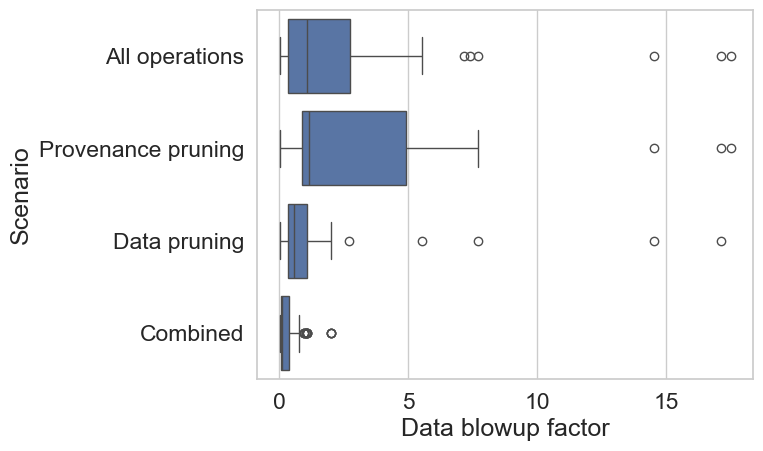

In [211]:
ax = sns.boxplot(gg2_combined, x="blowup", y="scenario")
ax.set_ylabel("Scenario")
ax.set_xlabel("Data blowup factor")
plt.savefig("/Users/gm/Downloads/blowup.svg", bbox_inches='tight')